<a href="https://colab.research.google.com/github/Ratna-Babu/Graph-Coloring-using-Neural-Network/blob/main/Graph_Coloring_using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric


In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.optim import Adam

# Load the Cora dataset
dataset = Planetoid(root='./data', name='Cora')

# Get the graph data (Cora dataset has a single graph)
graph_data = dataset[0]

# Check the graph data
print(graph_data)
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.num_edges}")
print(f"Node feature size: {graph_data.x.size(1)}")
print(f"Number of classes: {dataset.num_classes}")

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model
input_dim = graph_data.x.shape[1]  # Number of node features
hidden_dim = 64                    # Hidden layer size
output_dim = dataset.num_classes   # Number of classes (colors)

model = GCN(input_dim, hidden_dim, output_dim)
print(model)

# Prepare the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Use the predefined train and test masks from the dataset
train_mask = graph_data.train_mask
test_mask = graph_data.test_mask

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)  # Forward pass
    loss = criterion(out[train_mask], graph_data.y[train_mask])  # Loss computation
    loss.backward()  # Backpropagation
    optimizer.step()  # Optimizer step
    return loss.item()

# Testing loop
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted classes
        correct = (pred[test_mask] == graph_data.y[test_mask]).sum()  # Correct predictions
        acc = int(correct) / int(test_mask.sum())  # Accuracy
    return acc

# Training and testing loop
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Node feature size: 1433
Number of classes: 7
GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
)
Epoch: 010, Loss: 0.1020, Test Accuracy: 0.7970
Epoch: 020, Loss: 0.0035, Test Accuracy: 0.7800
Epoch: 030, Loss: 0.0006, Test Accuracy: 0.7800
Epoch: 040, Loss: 0.0003, Test Accuracy: 0.7770
Epoch: 050, Loss: 0.0002, Test Accuracy: 0.7740
Epoch: 060, Loss: 0.0001, Test Accuracy: 0.7740
Epoch: 070, Loss: 0.0001, Test Accuracy: 0.7750
Epoch: 080, Loss: 0.0001, Test Accuracy: 0.7740
Epoch: 090, Loss: 0.0001, Test Accuracy: 0.7750
Epoch: 100, Loss: 0.0001, Test Accuracy: 0.7750


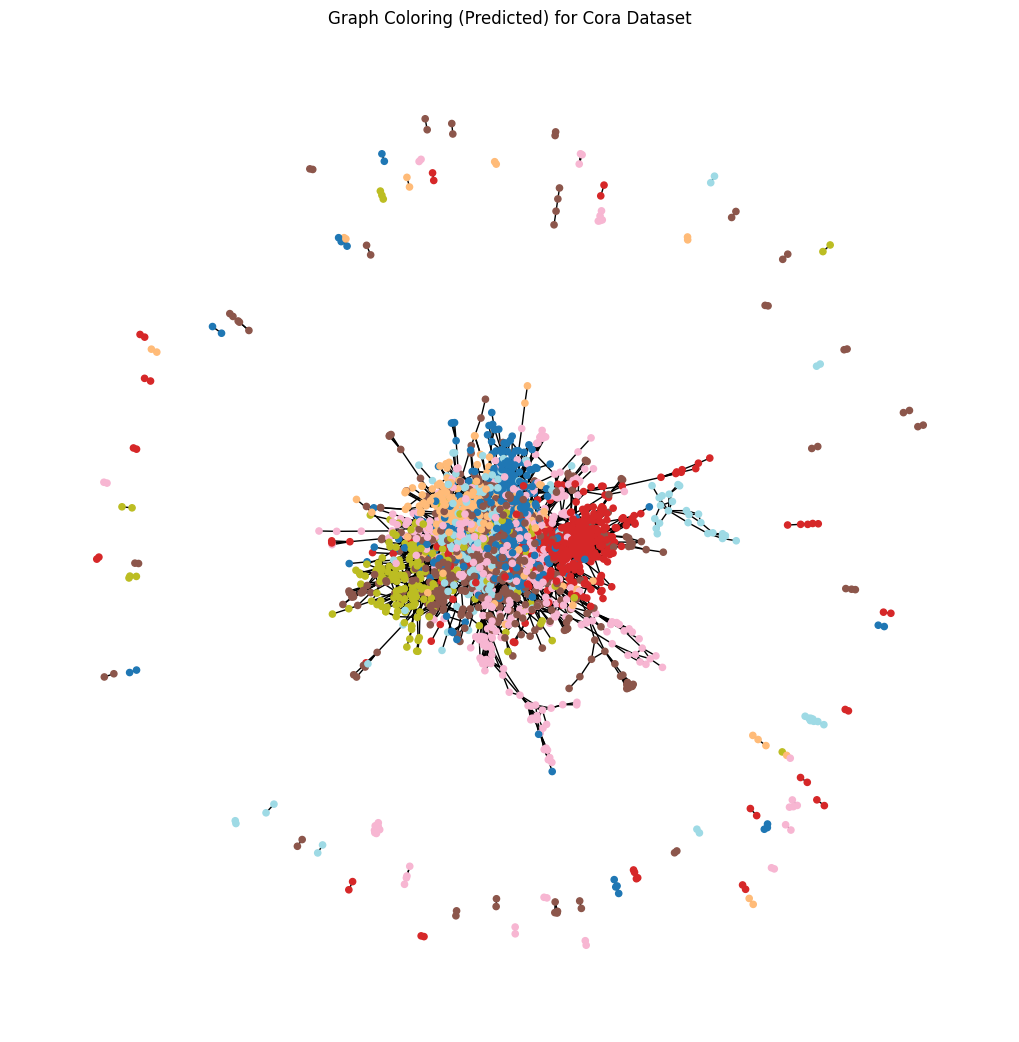

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

# Predict node colors (i.e., node classes for Cora dataset)
model.eval()
with torch.no_grad():
    out = model(graph_data.x, graph_data.edge_index)
    pred_colors = out.argmax(dim=1).numpy()

# Create a NetworkX graph from the Cora dataset (no need for an adjacency matrix)
cora_graph = nx.Graph()

# Add nodes with their predicted color (node class)
for i in range(graph_data.num_nodes):
    cora_graph.add_node(i, color=pred_colors[i])

# Add edges from the graph data
edge_list = graph_data.edge_index.t().numpy()  # Get the edges
for edge in edge_list:
    cora_graph.add_edge(edge[0], edge[1])

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(cora_graph)  # Layout for visualization
node_colors = [cora_graph.nodes[node]['color'] for node in cora_graph.nodes]  # Get predicted node colors
nx.draw(cora_graph, pos, node_color=node_colors, node_size=20, cmap=plt.cm.tab20)
plt.title("Graph Coloring (Predicted) for Cora Dataset")
plt.show()


Hyperparameter Tuning and Model Optimization:

Now that the basic model is working, it's time to optimize its performance. This involves tuning hyperparameters.



In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
from torch_geometric.nn import SAGEConv


# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_acc = None
        self.best_epoch = 0
        self.counter = 0

    def __call__(self, val_acc, epoch):
        if self.best_acc is None or val_acc - self.best_acc > self.delta:
            self.best_acc = val_acc
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            return True
        return False

# GraphSAGE Model Definition
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Evaluation Function
def evaluate_hyperparameters_with_scheduler(lr, hidden_dim, dropout, epochs):
    model = GraphSAGEModel(input_dim=graph_data.x.shape[1], hidden_dim=hidden_dim, output_dim=int(max(node_colors) + 1), dropout=dropout)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()

    early_stopping = EarlyStopping(patience=10)

    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph_data.x, graph_data.edge_index)
        loss = criterion(out[train_mask], graph_data.y[train_mask])
        loss.backward()
        optimizer.step()

        # Testing the model
        acc = test(model)  # Pass the model to the test function
        scheduler.step(loss)  # Update the learning rate based on loss
        best_acc = max(best_acc, acc)

        # Early stopping check
        if early_stopping(acc, epoch):
            print(f"Early stopping at epoch {epoch}")
            break

    return best_acc

# Test Function
def test(model):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        pred = out.argmax(dim=1)  # Predicted class labels
        correct = (pred[test_mask] == graph_data.y[test_mask]).sum()
        acc = correct / test_mask.sum().item()
    return acc

# Hyperparameter Grid Search
param_grid = {
    'learning_rate': [0.01, 0.005, 0.001],
    'hidden_dim': [32, 64, 128],
    'dropout': [0.0, 0.5],
    'epochs': [100, 150, 200]
}

best_acc = 0.0
best_params = {}

for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")
    acc = evaluate_hyperparameters_with_scheduler(
        lr=params['learning_rate'],
        hidden_dim=params['hidden_dim'],
        dropout=params['dropout'],
        epochs=params['epochs']
    )
    print(f"Accuracy for this setting: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_params = params

print(f"Best Accuracy: {best_acc:.4f} with parameters: {best_params}")


Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 32, 'learning_rate': 0.01}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15
Accuracy for this setting: 0.7850
Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 32, 'learning_rate': 0.005}
Early stopping at epoch 34
Accuracy for this setting: 0.7790
Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 32, 'learning_rate': 0.001}
Early stopping at epoch 93
Accuracy for this setting: 0.7580
Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.01}
Early stopping at epoch 14
Accuracy for this setting: 0.7850
Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.005}
Early stopping at epoch 27
Accuracy for this setting: 0.7870
Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.001}
Early stopping at epoch 60
Accuracy for this setting: 0.7700
Training with params: {'dropout': 0.0, 'epochs': 100, 'hidden_dim': 128, 'learning_rate': 0.01}
Early stopping at epoch 17
Accuracy for this setting: 0.803

In [7]:
torch.save(model.state_dict(), "best_model.pth")  # Save model
# Load model later
model.load_state_dict(torch.load("best_model.pth"))


<ipython-input-7-11eea95a6437>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Ensure the model is in evaluation mode
model.eval()

# Compute predictions
with torch.no_grad():
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)  # Predicted classes

# Extract test labels and predictions
pred = pred.cpu() if pred.is_cuda else pred
true_labels = graph_data.y[test_mask].cpu() if graph_data.y.is_cuda else graph_data.y[test_mask]

# Generate metrics
print("Classification Report:")
print(classification_report(true_labels, pred[test_mask]))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, pred[test_mask]))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       130
           1       0.67      0.88      0.76        91
           2       0.80      0.91      0.85       144
           3       0.93      0.66      0.77       319
           4       0.77      0.86      0.81       149
           5       0.84      0.72      0.77       103
           6       0.64      0.84      0.72        64

    accuracy                           0.78      1000
   macro avg       0.76      0.80      0.77      1000
weighted avg       0.80      0.78      0.78      1000


Confusion Matrix:
[[ 99   4   4   5   5   2  11]
 [  6  80   2   2   1   0   0]
 [  3   7 131   3   0   0   0]
 [ 22  19  21 209  32   8   8]
 [  8   3   2   4 128   2   2]
 [ 10   5   4   0   0  74  10]
 [  5   2   0   1   0   2  54]]


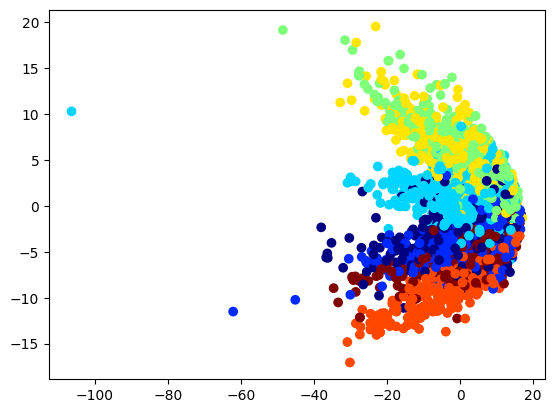

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
embeddings = pca.fit_transform(out.detach().numpy())
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=pred_colors, cmap="jet")
plt.show()


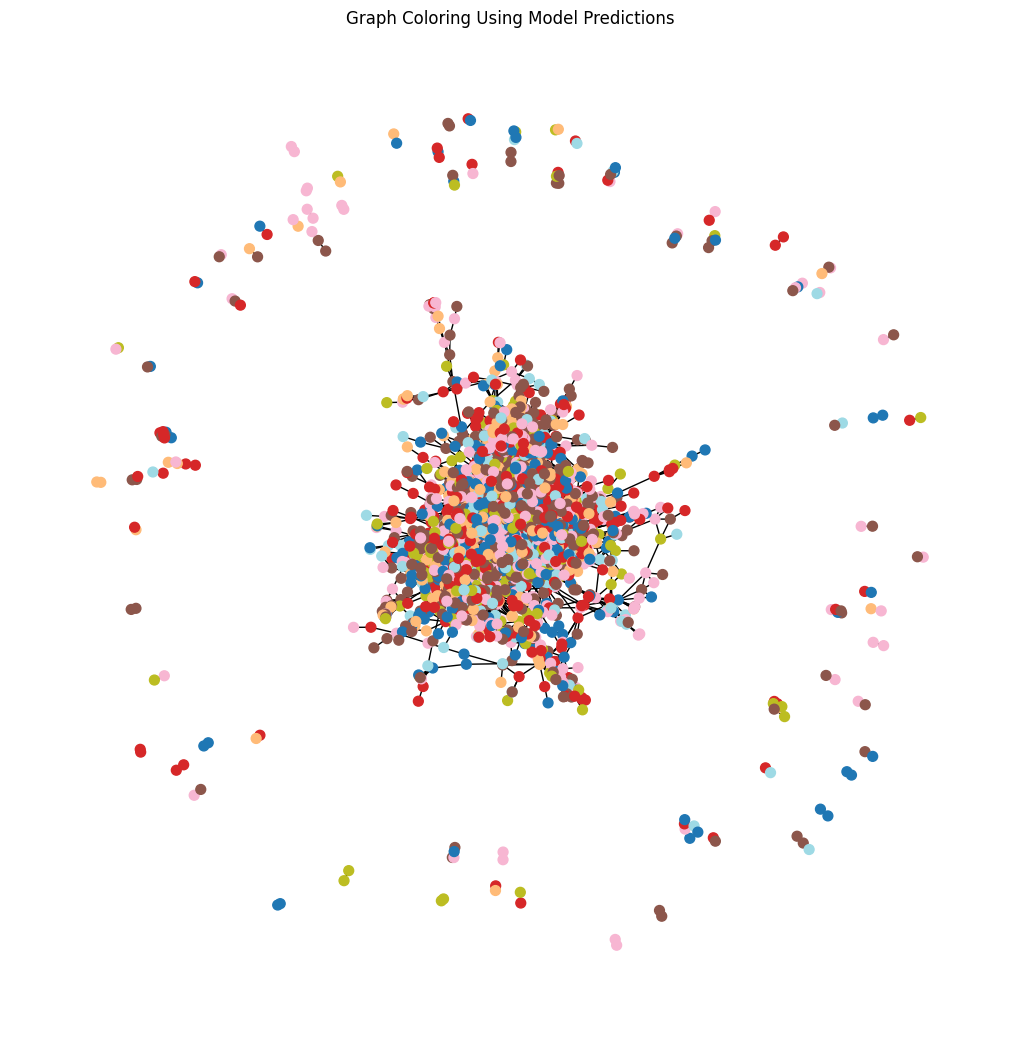

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Compute predictions
with torch.no_grad():
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)  # Predicted classes

# Convert predictions to CPU if using GPU
pred = pred.cpu() if pred.is_cuda else pred

# Create a NetworkX graph from PyTorch Geometric data
nx_graph = nx.Graph()
nx_graph.add_edges_from(graph_data.edge_index.cpu().numpy().T)

# Define positions for visualization
pos = nx.spring_layout(nx_graph, seed=42)  # Use a layout for positioning nodes

# Plot the graph with node colors based on predictions
plt.figure(figsize=(10, 10))
nx.draw(
    nx_graph,
    pos,
    node_color=pred.numpy(),  # Use predictions as node colors
    node_size=50,
    cmap=plt.cm.tab20,  # Colormap for distinct colors
    with_labels=False
)
plt.title("Graph Coloring Using Model Predictions")
plt.show()
